In [1]:
from itertools import islice
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from fairseq.data import data_utils
from fairseq.models.roberta import RobertaModel
from scipy.sparse import load_npz
from sklearn.metrics import precision_recall_curve
from tqdm import tqdm

sys.path.append('../..')
from go_annotation.ontology import Ontology

%matplotlib inline
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

In [2]:
torch.cuda.is_available()

True

### Load the roberta model that's been fine-tuned on swissprot GO annotations

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_model(checkpoint):
    roberta_model = RobertaModel.from_pretrained(
        '/projects/deepgreen/pstjohn/20210121_go_checkpoints/',
        data_name_or_path='/projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_swissprot/',
        checkpoint_file=checkpoint)

    _ = roberta_model.eval()  # disable dropout (or leave in train mode to finetune)
    _ = roberta_model.to(device)
    
    return roberta_model

roberta few functions for running model predictions and batching outputs

In [10]:
from fairseq.data.shorten_dataset import maybe_shorten_dataset

In [11]:
import logging

In [12]:
ont = Ontology()
_ancestor_array = ont.ancestor_array()


def normalize_logits(logits):
    bsz = logits.shape[0]
    index_tensor = logits.new_tensor(_ancestor_array, dtype=torch.int64)
    index_tensor = index_tensor.unsqueeze(0).expand((bsz, -1, -1))  # Array of ancestors, offset by one
    padded_logits = torch.nn.functional.pad(logits, (1, 0), value=float('inf'))  # Make 0 index return inf
    padded_logits = padded_logits.unsqueeze(-1).expand((-1, -1, index_tensor.shape[2]))
    normed_logits = torch.gather(padded_logits, 1, index_tensor)
    normed_logits, _ = torch.min(normed_logits, -1)

    return normed_logits


def encode(roberta_model, sequence):
    sequence = '<s> ' + sequence.replace('B', 'D').replace('Z', 'E').replace('J', 'L')
    encoded_sequence = roberta_model.task.source_dictionary.encode_line(sequence, add_if_not_exist=False)[:roberta_model.model.max_positions()]    
    return encoded_sequence


def inputs_generator(roberta_model, filename, batch_size):
    with open(filename, 'r') as f:
        encoded_lines = (encode(roberta_model, line) for line in f)
        for batch in iter(lambda: tuple(islice(encoded_lines, batch_size)), ()):
            yield data_utils.collate_tokens(
                batch, pad_idx=roberta_model.task.source_dictionary.pad()).long().to(device)

In [13]:
def run_predictions(roberta_model, dataset):

    inputs_filename = f'/projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_{dataset}/input0/test.raw'
    targets_filename = f'/projects/deepgreen/pstjohn/swissprot_go_annotation/fairseq_{dataset}/label/test.npz'
    batch_size = 16

    y_true = np.array(load_npz(targets_filename).todense())
    y_pred = []

    for inputs in tqdm(inputs_generator(roberta_model, inputs_filename, batch_size), total=int(np.ceil(y_true.shape[0] / batch_size))):

        assert inputs.shape[1] <= 1024
        assert inputs.max() <= 25

        with torch.no_grad():
            logits, _ = roberta_model.model(inputs, features_only=True, classification_head_name='go_prediction')

            normed_logits = normalize_logits(logits)
            batch_pred = torch.sigmoid(normed_logits)
            y_pred += [batch_pred.detach().cpu().numpy()]


    
    y_pred = np.concatenate(y_pred)
        
    # Split the predictions into groups based on which ontology tree they are under
    head_nodes = {ont.G.nodes[ont.term_index[index]]['name']: index for index in ont.get_head_node_indices()}
    y_true_bp = y_true[:, ont.terms_to_indices(ont.get_descendants(ont.term_index[head_nodes['biological_process']]))]
    y_pred_bp = y_pred[:, ont.terms_to_indices(ont.get_descendants(ont.term_index[head_nodes['biological_process']]))]
    y_true_mf = y_true[:, ont.terms_to_indices(ont.get_descendants(ont.term_index[head_nodes['molecular_function']]))]
    y_pred_mf = y_pred[:, ont.terms_to_indices(ont.get_descendants(ont.term_index[head_nodes['molecular_function']]))]
    y_true_cc = y_true[:, ont.terms_to_indices(ont.get_descendants(ont.term_index[head_nodes['cellular_component']]))]
    y_pred_cc = y_pred[:, ont.terms_to_indices(ont.get_descendants(ont.term_index[head_nodes['cellular_component']]))]

    # calculate precision recall scores for each
    precision_bp, recall_bp, thresholds_bp = precision_recall_curve(y_true_bp.flatten(), y_pred_bp.flatten())
    precision_mf, recall_mf, thresholds_mf = precision_recall_curve(y_true_mf.flatten(), y_pred_mf.flatten())
    precision_cc, recall_cc, thresholds_cc = precision_recall_curve(y_true_cc.flatten(), y_pred_cc.flatten())
    
    return {
        'precision_bp': precision_bp[::(len(precision_bp)//10000)],
        'recall_bp': recall_bp[::(len(recall_bp)//10000)], 
        'precision_mf': precision_mf[::(len(precision_mf)//10000)],
        'recall_mf': recall_mf[::(len(recall_mf)//10000)],
        'precision_cc': precision_cc[::(len(precision_cc)//10000)],
        'recall_cc': recall_cc[::(len(recall_cc)//10000)],
    }

In [14]:
outputs_cafa_preinit = run_predictions(load_model('cafa3_preinit.pt'), 'cafa3')
outputs_sp_preinit = run_predictions(load_model('swissprot_preinit.pt'), 'swissprot')
outputs_cafa_noinit = run_predictions(load_model('cafa3_noinit.pt'), 'cafa3')
outputs_sp_noinit = run_predictions(load_model('swissprot_noinit.pt'), 'swissprot')

100%|██████████| 624/624 [03:56<00:00,  2.64it/s]


In [181]:
def count_parameters(model):
    table = []
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table += [(name, param)]
        total_params+=param

    return table, total_params
    
count_parameters(load_model('swissprot_preinit.pt'))

([('model.encoder.sentence_encoder.embed_tokens.weight', 25344),
  ('model.encoder.sentence_encoder.embed_positions.weight', 787968),
  ('model.encoder.sentence_encoder.layers.0.self_attn.k_proj.weight', 589824),
  ('model.encoder.sentence_encoder.layers.0.self_attn.k_proj.bias', 768),
  ('model.encoder.sentence_encoder.layers.0.self_attn.v_proj.weight', 589824),
  ('model.encoder.sentence_encoder.layers.0.self_attn.v_proj.bias', 768),
  ('model.encoder.sentence_encoder.layers.0.self_attn.q_proj.weight', 589824),
  ('model.encoder.sentence_encoder.layers.0.self_attn.q_proj.bias', 768),
  ('model.encoder.sentence_encoder.layers.0.self_attn.out_proj.weight',
   589824),
  ('model.encoder.sentence_encoder.layers.0.self_attn.out_proj.bias', 768),
  ('model.encoder.sentence_encoder.layers.0.self_attn_layer_norm.weight', 768),
  ('model.encoder.sentence_encoder.layers.0.self_attn_layer_norm.bias', 768),
  ('model.encoder.sentence_encoder.layers.0.fc1.weight', 2359296),
  ('model.encoder.sent

In [15]:
def get_fmax(precision, recall):
    fscores = (2 * precision * recall / (precision + recall))
    fmax = fscores.max()
    argmax = fscores.argmax()
    return fmax, argmax

In [16]:
import pandas as pd

In [31]:
labels

[('swissprot', 'preinit'),
 ('swissprot', 'noinit'),
 ('cafa3', 'preinit'),
 ('cafa3', 'noinit')]

In [36]:
colors = sns.color_palette("Paired")

In [37]:
colors

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

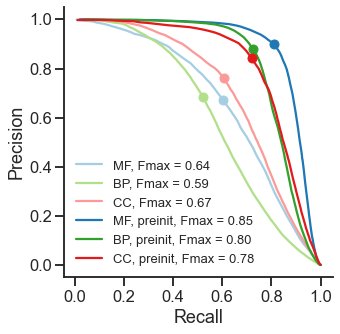

In [66]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, aspect='equal')


for j, target in enumerate(targets):

    color = colors[2*j]

    precision, recall = outputs[1][f'precision_{target}'], outputs[1][f'recall_{target}']
    fmax, argmax = get_fmax(precision, recall)
    ax.plot(recall, precision, color=color, label=f'{target.upper()}, Fmax = {fmax:.2f}')
    ax.plot(recall[argmax], precision[argmax], 'o', color=color)

for j, target in enumerate(targets):

    color = colors[2*j + 1]

    precision, recall = outputs[0][f'precision_{target}'], outputs[0][f'recall_{target}']
    fmax, argmax = get_fmax(precision, recall)
    ax.plot(recall, precision, color=color, label=f'{target.upper()}, preinit, Fmax = {fmax:.2f}')
    ax.plot(recall[argmax], precision[argmax], 'o', color=color)


    
ax.set_xticks(np.linspace(0, 1, 6, endpoint=True))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')

ax.legend(loc='lower left', fontsize=13)

plt.tight_layout()
sns.despine()

plt.savefig('fmax_swissprot.svg')

In [8]:
targets = ['mf', 'bp', 'cc']


In [70]:
fmax_df

,data,initialization,target,fmax
0,swissprot,preinit,mf,0.851612
1,swissprot,preinit,bp,0.795717
2,swissprot,preinit,cc,0.776481
3,swissprot,noinit,mf,0.636288
4,swissprot,noinit,bp,0.592012
5,swissprot,noinit,cc,0.674766
6,cafa3,preinit,mf,0.721755
7,cafa3,preinit,bp,0.623575
8,cafa3,preinit,cc,0.687273
9,cafa3,noinit,mf,0.566937


In [7]:
labels = [(data, init) for data in ['swissprot', 'cafa3'] for init in ['preinit', 'noinit']]
outputs = [outputs_sp_preinit, outputs_sp_noinit, outputs_cafa_preinit, outputs_cafa_noinit]
labels

def iter_fmax():
    for label, output in zip(labels, outputs):
        for target in targets:
            fmax = get_fmax(output[f'precision_{target}'], output[f'recall_{target}'])[0]
            yield (label[0], label[1], target.upper(), fmax)
            
fmax_df = pd.DataFrame(iter_fmax(), columns=['data', 'initialization', 'target', 'fmax'])

NameError: name 'outputs_sp_preinit' is not defined

In [161]:
offset_preinit = .2
offset_dataset = .45

fmax_df['x'] = fmax_df.target.replace({'BP': 1, 'CC': 2, 'MF': 0})
fmax_df['x'] += (fmax_df['initialization'] == 'preinit') * offset_preinit
fmax_df['x'] += (fmax_df['data'] == 'cafa3') * offset_dataset

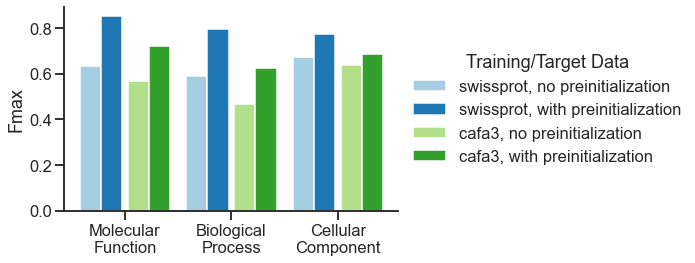

In [164]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

colors = sns.color_palette("Paired")
colors = [*colors[2:4], *colors[:2]]

for (labels, df), color in zip(fmax_df.groupby(['data', 'initialization']), colors):
    ax.bar(df.x, height=df.fmax, width=0.2, color=color, 
           label=f"{labels[0]}, {'with' if labels[1] == 'preinit' else 'no'} preinitialization", align='edge')
    
ax.set_xticks(np.arange(3) + .85/2)
ax.set_xticklabels(['Molecular\nFunction', 'Biological\nProcess', 'Cellular\nComponent', ])
ax.set_ylabel('Fmax')

handles, labels = ax.get_legend_handles_labels()

handles = [*handles[2:4], *handles[:2]]
labels = [*labels[2:4], *labels[:2]]

ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1., .5), title='Training/Target Data')

# ax.set_title('Performance on Uniref50 test data')

# # ax.bar(x=fmax_cafa.x, height=fmax_cafa.fmax, width=0.2, color=[:4] * 4)
# for (labels, df), color in zip(fmax_df[fmax_df.data == 'cafa3'].groupby(['data', 'initialization']), sns.color_palette("Paired")):
    
# ax.set_xticks(np.arange(3) + .85/2)
# ax.set_xticklabels(['Biological\nProcess', 'Cellular\nComponent', 'Molecular\nFunction'])
# #ax.set_ylabel('Fmax')
# ax.set_title('Performance on CAFA3 test data')
sns.despine()

plt.tight_layout()

plt.savefig('fmax.svg')

In [5]:
import os
import pandas as pd

In [142]:
targets

['mf', 'bp', 'cc']

In [160]:
targets

['mf', 'bp', 'cc']

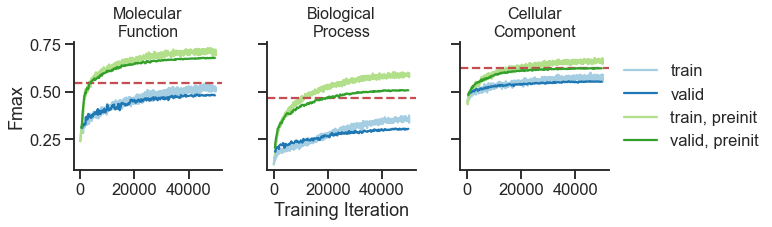

In [16]:
fig, axmatrix = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(9,3.5))
colors = sns.color_palette("Paired")

for file in os.listdir('training_curves/'):
    preinit = 'preinit' in file
    target = file[-12:-10]
    train = 'train' in file
    data = 'swissprot' if 'swissprot' in file else 'cafa3'
    
    if data == 'swissprot':
        continue
    
    color = colors[preinit * 2 + (1 - train)]
    
    log = pd.read_csv(os.path.join('training_curves/', file))
    
    ax = axmatrix[targets.index(target)]
    ax.plot(log.Step, log.Value, zorder=0 if train else 1, color=color,
            label=f"{'train' if train else 'valid'}{', preinit' if preinit else ''}")

    
axmatrix[0].set_ylabel('Fmax')
axmatrix[1].set_xlabel('Training Iteration')

titles = ['Molecular\nFunction', 'Biological\nProcess', 'Cellular\nComponent']
for title, ax in zip(titles, axmatrix):
    ax.set_title(title, fontsize=16)

plt.tight_layout()
sns.despine()


handles, labels = ax.get_legend_handles_labels()

handles = [handles[0], handles[1], handles[3], handles[2]]
labels = [labels[0], labels[1], labels[3], labels[2]]

axmatrix[2].legend(handles, labels, loc='center left', bbox_to_anchor=(1., .5))

axmatrix[0].axhline(0.544, color='r', zorder=0, ls='--')
axmatrix[1].axhline(0.469, color='r', zorder=0, ls='--')
axmatrix[2].axhline(0.623, color='r', zorder=0, ls='--')

plt.savefig('go_finetuning_cafa3.svg')

In [124]:
# fig = plt.figure(figsize=(8,4))
# ax1 = fig.add_subplot(121, aspect='equal')
# ax2 = fig.add_subplot(122, aspect='equal'ascending=for i, output in enumerate(outputs):
    
#     if i < 2:
#         ax = ax1
#     else:
#         ax = ax2
        
#     for j, target in enumerate(targets):
        
#         if (i % 2 == 0):
#             color = colors[2*j + 1]
#         else:
#             color = colors[2*j]
        
#         precision, recall = output[f'precision_{target}'], output[f'recall_{target}']
#         fmax, argmax = get_fmax(precision, recall)
#         ax.plot(recall, precision, color=color)
#         ax.plot(recall[argmax], precision[argmax], 'o', color=color)

# for ax in [ax1, ax2]:
#     ax.set_xticks(np.linspace(0, 1, 6, endpoint=True))
#     ax.set_xlabel('Recall')
#     ax.set_ylabel('Precision')
    
#     ax.legend(loc='lower left', fontsize=13)

# plt.tight_layout()
# sns.despine()